In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import os

import json
import torch
import wandb
import sys
from torch.utils.data import DataLoader, Subset, RandomSampler
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch.nn as nn
from torchmetrics.classification import BinaryF1Score
from torchmetrics import Dice

# Add the parent directory to sys.path
sys.path.append(os.path.dirname(os.path.realpath(os.path.abspath(""))))

from unet.dataset import DeadwoodDataset
from unet.dice_score import dice_coeff, confusion_values, confusion_tensor
from unet.evaluate import evaluate
from unet.unet_model import UNet
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
run_id = "4cy6fimu"

In [ ]:
# import importlib
# importlib.reload(sys.modules['unet.dice_score'])

In [4]:
api = wandb.Api()
experiment = api.run(f"jmoehring/standing-deadwood-unet-pro/{run_id}")

In [5]:
experiment.config

{'data': {'epochs': 20,
  'no_folds': 3,
  'test_size': 0.2,
  'batch_size': 16,
  'train_bins': [0, 0.04, 0.08, 0.12, 0.16, 0.2],
  'random_seed': 100,
  'register_file': '/net/scratch/jmoehring/tiles_register_1024_biome.csv',
  'balaning_factor': 1,
  'save_checkpoint': True,
  'epoch_val_samples': 2000,
  'epoch_train_samples': 10000},
 'model': {'amp': False,
  'epochs': 20,
  'momentum': 0.999,
  'weight_decay': 1e-08,
  'learning_rate': 1e-05,
  'gradient_clipping': 1}}

In [18]:
no_val_samples: int = 10000
epoch_models = [0, 14, 0]

fold: int = 1
epoch: int = epoch_models[fold]

# data paths
checkpoint_dir = f"/net/scratch/jmoehring/checkpoints/{experiment.name}"
model_checkpoint = f"fold_{fold}_epoch_{epoch}.pth"

# data params
no_folds: int = experiment.config["data"]["no_folds"]
random_seed: int = experiment.config["data"]["random_seed"]
batch_size: int = experiment.config["data"]["batch_size"]
test_size: float = experiment.config["data"]["test_size"]

In [19]:
register_df = pd.read_csv(experiment.config["data"]["register_file"])

In [20]:
dataset = DeadwoodDataset(
    register_df=register_df,
    no_folds=no_folds,
    random_seed=random_seed,
    test_size=0,
)

/net/home/jmoehring/standing-deadwood/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


In [21]:
loader_args = {
    "batch_size": 16,
    "num_workers": 12,
    "pin_memory": True,
    "shuffle": True,
}
_, val_set = dataset.get_train_val_fold(fold)

# only sample a subset of the validation set
if no_val_samples > 0:
    loader_args["shuffle"] = False
    sampler = RandomSampler(val_set, num_samples=no_val_samples)

val_loader = DataLoader(val_set, **loader_args, sampler=sampler)

In [22]:
# preferably use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model with three input channels (RGB)
model = UNet(n_channels=3, n_classes=1, bilinear=True)
model = nn.DataParallel(model)
model.load_state_dict(torch.load(os.path.join(checkpoint_dir, model_checkpoint)))
model = model.to(memory_format=torch.channels_last, device=device)

model.eval()

DataParallel(
  (module): UNet(
    (inc): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down1): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(128, 128, 

In [11]:
run_name = f"{experiment.name}_fold_{fold}_epoch_{epoch}_eval"
wandb.init(project="standing-deadwood-unet-pro", name=run_name, resume=False)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jmoehring. Use `wandb login --relogin` to force relogin


In [23]:
image_count = 0

eval_df = pd.DataFrame(columns=["biome", "resolution_bin", "precision", "recall", "f1"])
for batch, (images, true_masks, images_metas) in tqdm(
    enumerate(val_loader), total=len(val_loader)
):
    images = images.to(memory_format=torch.channels_last, device=device)
    true_masks = true_masks.to(device=device)

    with torch.no_grad():
        pred_masks = model(images)
        pred_masks = torch.sigmoid(pred_masks)
        pred_masks_sig = (pred_masks > 0.5).float()
        precision, recall, f1 = confusion_values(
            pred_masks_sig.squeeze(), true_masks.squeeze()
        )
        # extend the dataframe by all the results of the batch
        for i in range(len(images)):
            eval_row = pd.DataFrame(
                {
                    "biome": [images_metas["biome"][i].item()],
                    "resolution_bin": [images_metas["resolution_bin"][i].item()],
                    "precision": [precision[i].numpy()],
                    "recall": [recall[i].numpy()],
                    "f1": [f1[i].numpy()],
                },
            )
            eval_df = pd.concat([eval_df, eval_row])
            # if image_count < 50 and true_masks[i].sum() > 0:
            #     merged_confusion_tensor = confusion_tensor(
            #         pred_masks_sig[i].squeeze(), true_masks[i].squeeze()
            #     )
            #     wandb.log(
            #         {
            #             "segmentation": wandb.Image(
            #                 images[i].float().cpu(),
            #                 masks={
            #                     "confusion": {
            #                         "mask_data": merged_confusion_tensor.float()
            #                         .cpu()
            #                         .squeeze()
            #                         .numpy(),
            #                         "class_labels": {
            #                             1: "true_positive",
            #                             2: "false_positive",
            #                             3: "false_negative",
            #                         },
            #                     },
            #                 },
            #             )
            #         }
            #     )
            #     image_count += 1

100%|██████████| 625/625 [08:41<00:00,  1.20it/s]


In [24]:
eval_df["f1"] = eval_df["f1"].astype(float)
eval_df["precision"] = eval_df["precision"].astype(float)
eval_df["recall"] = eval_df["recall"].astype(float)

In [25]:
eval_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 0
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   biome           10000 non-null  float64
 1   resolution_bin  10000 non-null  float64
 2   precision       3258 non-null   float64
 3   recall          3420 non-null   float64
 4   f1              2049 non-null   float64
dtypes: float64(5)
memory usage: 468.8 KB


In [26]:
eval_df.to_csv(
    f"/net/scratch/jmoehring/eval_{experiment.name}_fold_{fold}_epoch_{epoch}.csv"
)

In [ ]:
# eval_df = pd.read_csv(
#     f"/net/scratch/jmoehring/eval_{experiment.name}_fold_{fold}_epoch_{epoch}.csv"
# )

In [27]:
# add new column biome names
biome_names = {
    4: "Temperate Broadleaf and Mixed Forests",
    5: "Temperate Coniferous Forests",
    6: "Boreal Forests/Taiga",
    12: "Mediteranean Forests",
}
eval_df["biome_name"] = eval_df["biome"].map(biome_names)

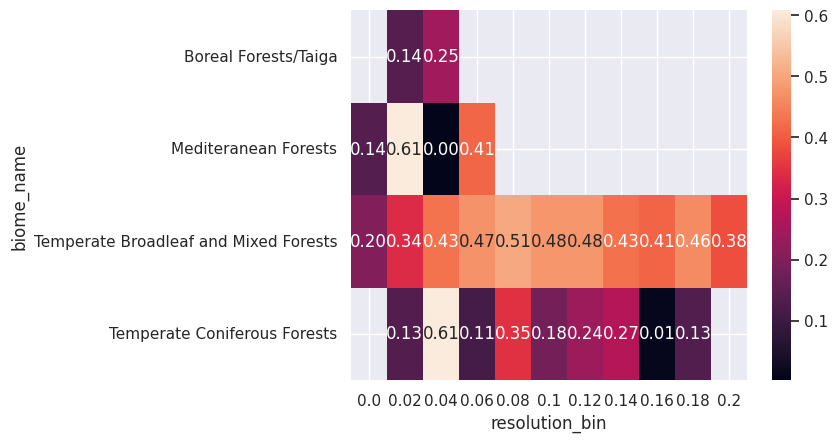

In [28]:
# plot seaborn heatmap of dice scores with biome and resolution as x and y axis
sns.set_theme()
pivoted = eval_df.pivot_table(index="biome_name", columns="resolution_bin", values="f1")
sns.heatmap(pivoted, cmap="rocket", annot=True, fmt=".2f")
plt.show()